In [ ]:
speed_ref_rpm = np.ones(1000000)  # 1000 RPM for the entire simulation
speed_ref_rpm[1:500000] *= 1000
speed_ref_rpm[500000:] *= 1500


array([1.0e+00, 1.0e+03, 1.0e+03, ..., 1.5e+03, 1.5e+03, 1.5e+03],
      shape=(1000000,))

In [11]:
import numpy as np
import matplotlib.pyplot as plt
#i have pulled it
class SwitchedReluctanceMotor:
    """
    This class defines the Switched Reluctance Motor model.
    It calculates inductance, its derivative, and the electromagnetic torque
    based on the motor's physical parameters and current state.
    """
    def __init__(self, phase=3, Ns=12, Nr=8, R=0.9, J=0.01, B=0.005, La=0.154, Lu=0.023):
        """
        Initializes the SRM with parameters from the specification sheet.
        """
        self.phase = phase
        self.Ns = Ns  # Number of stator poles
        self.Nr = Nr  # Number of rotor poles
        self.R = R    # Stator resistance per phase [Ohm]
        self.J = J    # Moment of inertia [kg.m^2]
        self.B = B    # Friction coefficient [N.m.s]
        self.La = La  # Aligned inductance [H]
        self.Lu = Lu  # Unaligned inductance [H]
        
        # Calculate phase shift between phases in mechanical radians
        # This is the step angle for commutation
        self.phase_shift = (2 * np.pi) / (self.phase * self.Nr)

    def inductance(self, theta_m, phase_index):
        """
        Calculates the inductance of a given phase at a specific mechanical rotor angle.
        This uses a simplified triangular approximation for the inductance profile.
        
        Args:
            theta_m (float): Mechanical rotor angle [rad].
            phase_index (int): The index of the phase (0 for A, 1 for B, 2 for C).
            
        Returns:
            float: Inductance of the specified phase [H].
        """
        # Electrical angle for the given phase, considering the phase shift
        theta_e = (self.Nr * (theta_m - phase_index * self.phase_shift)) % (2 * np.pi)

        # Triangular inductance profile over one electrical period (2*pi)
        if 0 <= theta_e < np.pi:
            # Linearly increasing inductance
            return self.Lu + (self.La - self.Lu) * (theta_e / np.pi)
        else: # pi <= theta_e < 2*pi
            # Linearly decreasing inductance
            return self.La - (self.La - self.Lu) * ((theta_e - np.pi) / np.pi)

    def dL_dtheta(self, theta_m, phase_index):
        """
        Calculates the derivative of inductance with respect to the mechanical rotor angle.
        
        Args:
            theta_m (float): Mechanical rotor angle [rad].
            phase_index (int): The index of the phase (0 for A, 1 for B, 2 for C).
            
        Returns:
            float: The derivative of inductance [H/rad].
        """
        theta_e = (self.Nr * (theta_m - phase_index * self.phase_shift)) % (2 * np.pi)

        # Derivative for the triangular profile
        if 0 <= theta_e < np.pi:
            # Positive slope region (good for motoring)
            return self.Nr * (self.La - self.Lu) / np.pi
        else: # pi <= theta_e < 2*pi
            # Negative slope region (generating/braking)
            return -self.Nr * (self.La - self.Lu) / np.pi

    def torque(self, currents, theta_m):
        """
        Calculates the total electromagnetic torque produced by all phases.
        Torque = 0.5 * i^2 * dL/dtheta
        
        Args:
            currents (list): A list of currents for each phase [A].
            theta_m (float): Mechanical rotor angle [rad].
            
        Returns:
            float: Total electromagnetic torque [N.m].
        """
        total_torque = 0.0
        for i in range(self.phase):
            total_torque += 0.5 * (currents[i]**2) * self.dL_dtheta(theta_m, i)
        return total_torque


class PIController:
    """A simple Proportional-Integral (PI) controller."""
    def __init__(self, Kp, Ki, output_min, output_max):
        self.Kp = Kp
        self.Ki = Ki
        self.output_min = output_min
        self.output_max = output_max
        self.integral = 0.0
        self.prev_error = 0.0

    def update(self, error, dt):
        """Calculates the control output."""
        self.integral += error * dt
        # Anti-windup for the integral term
        self.integral = max(min(self.integral, self.output_max), self.output_min)
        
        output = self.Kp * error + self.Ki * self.integral
        
        # Clamp output to its limits
        output = max(min(output, self.output_max), self.output_min)
        return output

class HysteresisController:
    """A hysteresis-based current controller."""
    def __init__(self, band):
        self.band = band

    def update(self, i_ref, i_actual):
        """
        Determines the voltage switch state based on current error.
        Returns 1 to turn ON, 0 to turn OFF.
        """
        if i_actual < i_ref - self.band:
            return 1  # Turn ON
        elif i_actual > i_ref + self.band:
            return 0  # Turn OFF
        else:
            return None # Keep previous state


def simulate_srm_control():
    """Main function to run the closed-loop simulation."""
    print("Starting SRM simulation...")
    
    # --- Simulation Parameters ---
    T_sim = 1.0  # Total simulation time [s]
    dt = 1e-6    # Time step [s] - needs to be small for numerical stability
    N = int(T_sim / dt)

    # --- Motor and Controller Setup ---
    srm = SwitchedReluctanceMotor()
    
    # PI controller for speed loop (gains may need tuning)
    # Kp=0.5, Ki=10 provides a reasonably good response
    speed_pi = PIController(Kp=0.5, Ki=10.0, output_min=0, output_max=10.0) # Output is current reference [A]
    
    # Hysteresis current controller
    hysteresis_band = 0.1 # [A]
    current_controller = HysteresisController(hysteresis_band)
    
    # --- System Parameters ---
    V_dc = 300.0  # DC bus voltage [V]
    T_load = 5.0  # Load torque [N.m]

    # --- Commutation Logic Parameters (in mechanical degrees) ---
    theta_on_deg = 0.0
    theta_off_deg = 20.0  # Should be less than 360/Nr = 45 deg
    
    theta_on = np.deg2rad(theta_on_deg)
    theta_off = np.deg2rad(theta_off_deg)
    
    # --- State Variables Initialization ---
    theta_m = 0.0          # Mechanical angle [rad]
    omega_m = 0.0          # Mechanical speed [rad/s]
    currents = [0.0] * srm.phase
    voltages = [0.0] * srm.phase
    switch_states = [0] * srm.phase
    
    # --- Data Logging ---
    log_interval = 100 # Log data every 100 steps to save memory
    time_log = []
    speed_log = []
    torque_log = []
    currents_log = [[] for _ in range(srm.phase)]
    ref_speed_log = []

    # --- Main Simulation Loop ---
    # Set speed reference (in RPM, converted to rad/s)
    speed_ref_rpm = 1000.0
    speed_ref_rads = speed_ref_rpm * (2 * np.pi / 60)

    for i in range(N):
        # --- Speed Control Loop ---
        speed_error = speed_ref_rads - omega_m
        i_ref = speed_pi.update(speed_error, dt)

        # --- Commutation and Current Control Loop ---
        for ph in range(srm.phase):
            # Calculate the effective angle for this phase
            theta_eff = (theta_m - ph * srm.phase_shift) % ((2 * np.pi) / srm.Nr)

            # Commutation Logic: Is this phase active?
            if theta_on <= theta_eff < theta_off:
                # Active window: use hysteresis control with +Vdc and 0V (soft chopping)
                new_state = current_controller.update(i_ref, currents[ph])
                if new_state is not None:
                    switch_states[ph] = new_state
                
                voltages[ph] = V_dc if switch_states[ph] == 1 else 0.0
            else:
                # Inactive window: force demagnetization with -Vdc
                switch_states[ph] = 0 # Phase is definitely off
                if currents[ph] > 0.01: # Use a small threshold to avoid chatter
                    voltages[ph] = -V_dc
                else:
                    voltages[ph] = 0.0

        # --- Motor Dynamics (Solving ODEs using Euler method) ---
        di_dt = [0.0] * srm.phase
        inductances = [srm.inductance(theta_m, ph) for ph in range(srm.phase)]
        dL_dthetas = [srm.dL_dtheta(theta_m, ph) for ph in range(srm.phase)]
        
        # Back-EMF term
        back_emf = [dL_dthetas[ph] * omega_m * currents[ph] for ph in range(srm.phase)]

        for ph in range(srm.phase):
            # V = R*i + L*di/dt + back_emf
            di_dt[ph] = (voltages[ph] - srm.R * currents[ph] - back_emf[ph]) / inductances[ph]
            currents[ph] += di_dt[ph] * dt
            currents[ph] = max(0, currents[ph]) # Current cannot be negative

        # Mechanical dynamics
        T_e = srm.torque(currents, theta_m)
        domega_dt = (T_e - T_load - srm.B * omega_m) / srm.J
        
        omega_m += domega_dt * dt
        theta_m += omega_m * dt
        theta_m %= (2 * np.pi) # Keep angle within one revolution

        # --- Logging ---
        if i % log_interval == 0:
            time_log.append(i * dt)
            speed_log.append(omega_m * 60 / (2 * np.pi)) # store in RPM
            torque_log.append(T_e)
            ref_speed_log.append(speed_ref_rpm)
            for ph in range(srm.phase):
                currents_log[ph].append(currents[ph])

    print("Simulation finished.")
    return time_log, speed_log, ref_speed_log, torque_log, currents_log


def plot_results(time, speed, ref_speed, torque, currents):
    """Plots the simulation results."""
    fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
    
    # Speed Plot
    axs[0].plot(time, speed, label='Actual Speed')
    axs[0].plot(time, ref_speed, 'r--', label='Reference Speed')
    axs[0].set_ylabel('Speed (RPM)')
    axs[0].set_title('SRM Closed-Loop Speed Control Simulation')
    axs[0].legend()
    axs[0].grid(True)

    # Torque Plot
    axs[1].plot(time, torque)
    axs[1].set_ylabel('Electromagnetic Torque (N.m)')
    axs[1].grid(True)

    # Current Plot
    for i, i_phase in enumerate(currents):
        axs[2].plot(time, i_phase, label=f'Phase {chr(65+i)} Current')
    axs[2].set_ylabel('Phase Current (A)')
    axs[2].set_xlabel('Time (s)')
    axs[2].legend()
    axs[2].grid(True)
    
    plt.tight_layout()
    plt.show()



In [12]:

# Run simulation
time, speed, ref_speed, torque, currents = simulate_srm_control()


Starting SRM simulation...
Simulation finished.


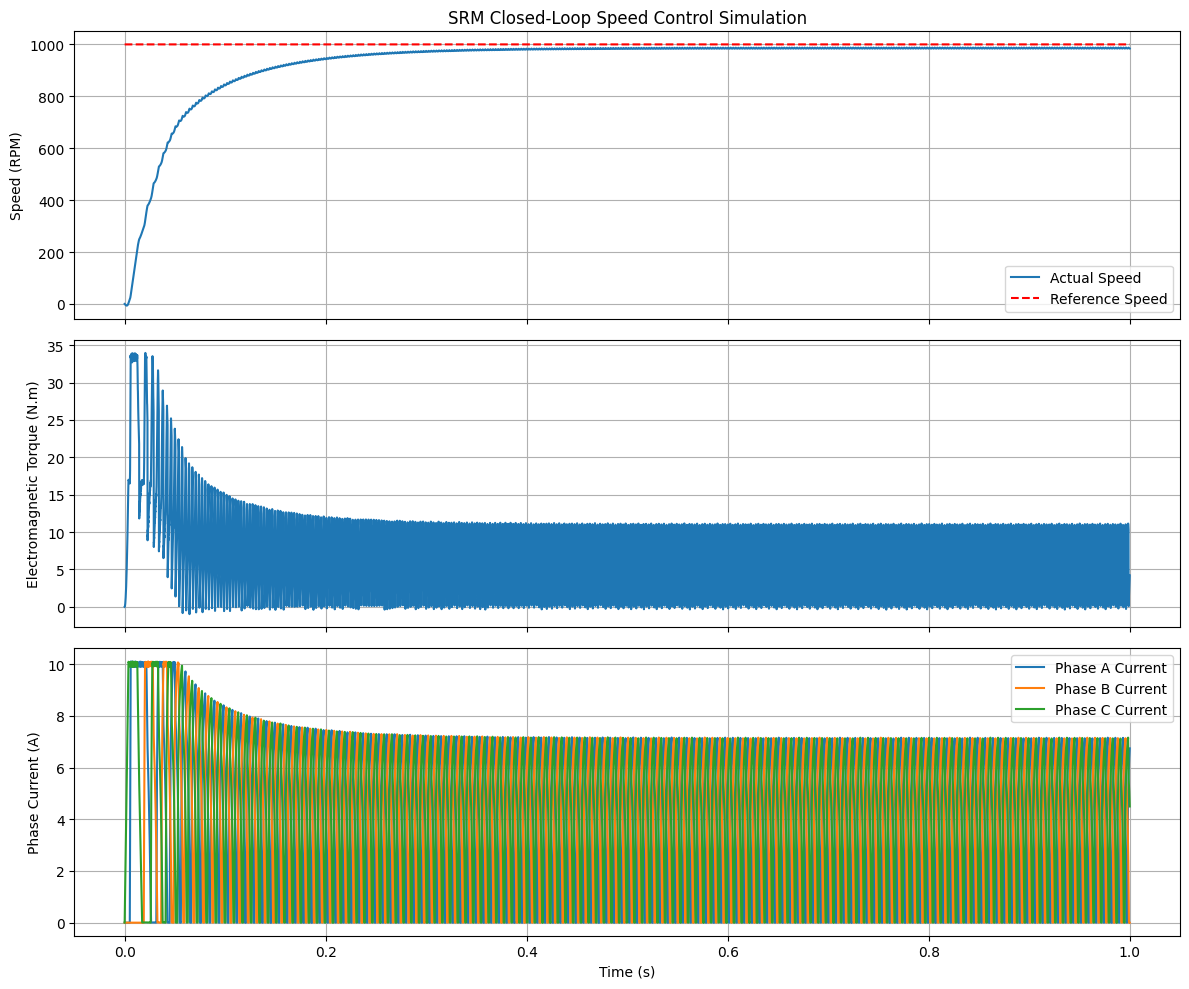

In [13]:

# Plot results
plot_results(time, speed, ref_speed, torque, currents)



In [3]:
pip install deap 

Note: you may need to restart the kernel to use updated packages.


## Dynamics of a Switched Reluctance Motor (SRM)

A Switched Reluctance Motor (SRM) produces torque based on the principle of reluctance minimization: the rotor tends to move to a position where the magnetic reluctance is minimum. Unlike induction or permanent magnet machines, the SRM relies entirely on variable inductance for torque production.

### Motor Parameters

- **Ns**: Number of stator poles  
- **Nr**: Number of rotor poles  
- **m**: Number of motor phases  
- **R**: Phase resistance  
- **J**: Rotor inertia  
- **B**: Viscous friction coefficient  
- **La**: Aligned inductance  
- **Lu**: Unaligned inductance  

### Electrical Dynamics

For each phase winding, the voltage equation is:

$$
v_i = R i_i + \frac{d\psi_i}{dt}
$$

with flux linkage defined as:

$$
\psi_i = L(\theta) \cdot i_i
$$

Since inductance depends on rotor position $\theta$:

$$
\frac{d\psi_i}{dt} = L(\theta) \frac{di_i}{dt} + i_i \frac{dL(\theta)}{d\theta} \cdot \frac{d\theta}{dt}
$$

### Inductance Profile

The phase inductance varies periodically with rotor position:

$$
L(\theta) =
\begin{cases} 
L_u + (L_a - L_u) \dfrac{\theta_e}{\pi}, & 0 \leq \theta_e < \pi \\
L_a - (L_a - L_u) \dfrac{\theta_e - \pi}{\pi}, & \pi \leq \theta_e < 2\pi
\end{cases}
$$

- **Aligned position**: $L = L_a$ (maximum)
- **Unaligned position**: $L = L_u$ (minimum)
#### Inductance Derivative: $\frac{dL(\theta)}{d\theta}$

The function `dL_dtheta(self, theta_m, phase_index)` computes the derivative of phase inductance with respect to rotor position. This is crucial for torque calculation in SRMs.

- The inductance profile $L(\theta)$ is piecewise linear (triangular) over one electrical cycle.
- For $0 \leq \theta_e < \pi$, $L(\theta)$ increases linearly, so its derivative is constant and positive.
- For $\pi \leq \theta_e < 2\pi$, $L(\theta)$ decreases linearly, so its derivative is constant and negative.

Mathematically:
- For the rising edge: $\frac{dL}{d\theta} = \frac{L_a - L_u}{\pi}$
- For the falling edge: $\frac{dL}{d\theta} = -\frac{L_a - L_u}{\pi}$

The code multiplies this slope by the number of rotor poles (`self.Nr`) to convert mechanical angle to electrical angle, since $\theta_e = N_r (\theta_m - \text{phase shift})$.

Thus, the function returns:
- $+\frac{N_r (L_a - L_u)}{\pi}$ when inductance is increasing (motoring region)
- $-\frac{N_r (L_a - L_u)}{\pi}$ when inductance is decreasing (generating/braking region)

This partial derivative quantifies how quickly the inductance changes with rotor position, directly impacting the electromagnetic torque produced by the motor.
### Electromagnetic Torque

The instantaneous electromagnetic torque is derived from the co-energy:

$$
T_e = \frac{1}{2} i^2 \frac{dL(\theta)}{d\theta}
$$

- If $\frac{dL}{d\theta} > 0$, the motor produces positive torque (motoring).
- If $\frac{dL}{d\theta} < 0$, the torque is negative (braking).

For a multi-phase SRM:

$$
T_{em} = \sum_{i=1}^{m} \frac{1}{2} i_i^2 \frac{dL_i(\theta)}{d\theta}
$$

### Mechanical Dynamics

The rotor motion is governed by Newton’s second law for rotation:

$$
J \frac{d\omega}{dt} + B \omega = T_{em} - T_L
$$

$$
\frac{d\theta}{dt} = \omega
$$

where:

- $J$: rotor inertia
- $B$: damping coefficient
- $\omega$: angular velocity
- $T_{em}$: electromagnetic torque
- $T_L$: load torque

### Implementation in Code

In a simulation framework, the dynamics can be expressed as:

- `inductance(theta_m, phase_index)` — computes phase inductance as a function of rotor position
- `dL_dtheta(theta_m, phase_index)` — derivative of inductance with respect to position
- `torque(currents, theta_m)` — electromagnetic torque from all phases

This formulation links the **electrical subsystem** (flux and torque generation) with the **mechanical subsystem** (rotor motion).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from deap import base, creator, tools, algorithms
# Attempt to import DEAP, provide installation instructions if it fails

# --- 2. Motor and Controller Models ---
class SwitchedReluctanceMotor:
    """
    This class defines the Switched Reluctance Motor model.
    It calculates inductance, its derivative, and the electromagnetic torque
    based on the motor's physical parameters and current state.
    """
    def __init__(self, phase=3, Ns=12, Nr=8, R=0.9, J=0.01, B=0.005, La=0.154, Lu=0.023):
        self.phase, self.Ns, self.Nr, self.R, self.J, self.B, self.La, self.Lu = phase, Ns, Nr, R, J, B, La, Lu
        self.phase_shift = (2 * np.pi) / (self.phase * self.Nr)

    def inductance(self, theta_m, phase_index):
        theta_e = (self.Nr * (theta_m - phase_index * self.phase_shift)) % (2 * np.pi)
        if 0 <= theta_e < np.pi:
            return self.Lu + (self.La - self.Lu) * (theta_e / np.pi)
        else:
            return self.La - (self.La - self.Lu) * ((theta_e - np.pi) / np.pi)

    def dL_dtheta(self, theta_m, phase_index):
        theta_e = (self.Nr * (theta_m - phase_index * self.phase_shift)) % (2 * np.pi)
        if 0 <= theta_e < np.pi:
            return self.Nr * (self.La - self.Lu) / np.pi
        else:
            return -self.Nr * (self.La - self.Lu) / np.pi

    def torque(self, currents, theta_m):
        total_torque = 0.0
        for i in range(self.phase):
            total_torque += 0.5 * (currents[i]**2) * self.dL_dtheta(theta_m, i)
        return total_torque

class PIController:
    """A simple Proportional-Integral (PI) controller."""
    def __init__(self, Kp, Ki, output_min, output_max):
        self.Kp, self.Ki, self.output_min, self.output_max = Kp, Ki, output_min, output_max
        self.integral = 0.0

    def update(self, error, dt):
        self.integral += error * dt
        self.integral = max(min(self.integral, self.output_max), self.output_min)
        output = self.Kp * error + self.Ki * self.integral
        return max(min(output, self.output_max), self.output_min)

class HysteresisController:
    """A hysteresis-based current controller."""
    def __init__(self, band):
        self.band = band

    def update(self, i_ref, i_actual):
        if i_actual < i_ref - self.band:
            return 1
        elif i_actual > i_ref + self.band:
            return 0
        else:
            return None


## PI and Hysteresis Controllers in SRM Motor Control

### PI Controller (Proportional-Integral)

The **PI controller** is used for speed regulation in the SRM drive. It compares the desired speed (reference) with the actual rotor speed and computes the error. The controller then generates a current reference (`i_ref`) for the motor phases using:

- **Proportional term (`Kp`)**: Reacts to the current error, providing immediate correction.
- **Integral term (`Ki`)**: Accumulates past errors, eliminating steady-state offset.

The PI controller output is:

$$
i_{ref} = K_p \cdot \text{error} + K_i \int \text{error} \, dt
$$

This current reference is passed to the phase current controllers.

### Hysteresis Controller

The **hysteresis controller** is used for phase current regulation. It maintains the actual phase current within a specified band around the reference (`i_ref`). The logic is:

- If $i_{actual} < i_{ref} - \text{band}$: Switch ON (apply positive voltage)
- If $i_{actual} > i_{ref} + \text{band}$: Switch OFF (apply zero or negative voltage)
- Otherwise: Keep previous switch state

This approach provides fast current response and is robust to parameter variations, making it suitable for SRM's highly nonlinear inductance profile.

### Workflow Summary

1. **Speed PI controller** sets the desired phase current.
2. **Hysteresis controller** switches the phase voltage to keep current within bounds.
3. This cascaded control ensures accurate speed tracking and effective torque production in the SRM.

In [ ]:

# --- 3. The Fitness Function ---
def run_simulation_for_ga(individual):
    """
    Runs the SRM simulation for a given set of parameters (an 'individual')
    and returns the torque ripple as a fitness score.
    """
    theta_on_deg, theta_off_deg, Kp, Ki = individual
    
    T_sim, dt = 0.75, 5e-6
    N = int(T_sim / dt)
    
    srm = SwitchedReluctanceMotor()
    speed_pi = PIController(Kp=Kp, Ki=Ki, output_min=0, output_max=15.0)
    current_controller = HysteresisController(band=0.1)
    
    V_dc, T_load = 300.0, 5.0
    theta_on, theta_off = np.deg2rad(theta_on_deg), np.deg2rad(theta_off_deg)
    
    theta_m, omega_m = 0.0, 0.0
    currents = [0.0] * srm.phase
    switch_states = [0] * srm.phase
    torque_log = []
    
    speed_ref_rads = 1000.0 * (2 * np.pi / 60)
    
    for i in range(N):
        speed_error = speed_ref_rads - omega_m
        i_ref = speed_pi.update(speed_error, dt)
        
        voltages = [0.0] * srm.phase
        for ph in range(srm.phase):
            theta_eff = (theta_m - ph * srm.phase_shift) % ((2 * np.pi) / srm.Nr)
            if theta_on <= theta_eff < theta_off:
                new_state = current_controller.update(i_ref, currents[ph])
                if new_state is not None: switch_states[ph] = new_state
                voltages[ph] = V_dc if switch_states[ph] == 1 else 0.0
            else:
                switch_states[ph] = 0
                if currents[ph] > 0.01: voltages[ph] = -V_dc
        
        T_e = srm.torque(currents, theta_m)
        
        inductances = [srm.inductance(theta_m, ph) for ph in range(srm.phase)]
        back_emf = [srm.dL_dtheta(theta_m, ph) * omega_m * currents[ph] for ph in range(srm.phase)]
        for ph in range(srm.phase):
            di_dt = (voltages[ph] - srm.R * currents[ph] - back_emf[ph]) / inductances[ph]
            currents[ph] = max(0, currents[ph] + di_dt * dt)
            
        domega_dt = (T_e - T_load - srm.B * omega_m) / srm.J
        omega_m += domega_dt * dt
        theta_m = (theta_m + omega_m * dt) % (2 * np.pi)
        
        if i > N / 2:
            torque_log.append(T_e)

    torque_ripple = np.std(torque_log) if torque_log else float('inf')
    return (torque_ripple,)

# --- 4. Final Simulation and Plotting ---
def run_final_simulation(individual):
    """Runs a full simulation with the provided parameters for plotting."""
    print("\nRunning final simulation with optimized parameters...")
    theta_on_deg, theta_off_deg, Kp, Ki = individual
    
    T_sim, dt, log_interval = 1.0, 1e-6, 100
    N = int(T_sim / dt)
    
    srm = SwitchedReluctanceMotor()
    speed_pi = PIController(Kp=Kp, Ki=Ki, output_min=0, output_max=15.0)
    current_controller = HysteresisController(band=0.1)
    
    V_dc, T_load = 300.0, 5.0
    theta_on, theta_off = np.deg2rad(theta_on_deg), np.deg2rad(theta_off_deg)
    
    theta_m, omega_m = 0.0, 0.0
    currents = [0.0] * srm.phase
    switch_states = [0] * srm.phase
    
    time_log, speed_log, torque_log = [], [], []
    currents_log = [[] for _ in range(srm.phase)]
    ref_speed_log = []

    speed_ref_rpm = 1000.0
    speed_ref_rads = speed_ref_rpm * (2 * np.pi / 60)
    
    for i in range(N):
        speed_error = speed_ref_rads - omega_m
        i_ref = speed_pi.update(speed_error, dt)
        
        voltages = [0.0] * srm.phase
        for ph in range(srm.phase):
            theta_eff = (theta_m - ph * srm.phase_shift) % ((2 * np.pi) / srm.Nr)
            if theta_on <= theta_eff < theta_off:
                new_state = current_controller.update(i_ref, currents[ph])
                if new_state is not None: switch_states[ph] = new_state
                voltages[ph] = V_dc if switch_states[ph] == 1 else 0.0
            else:
                switch_states[ph] = 0
                if currents[ph] > 0.01: voltages[ph] = -V_dc
        
        T_e = srm.torque(currents, theta_m)
        
        inductances = [srm.inductance(theta_m, ph) for ph in range(srm.phase)]
        back_emf = [srm.dL_dtheta(theta_m, ph) * omega_m * currents[ph] for ph in range(srm.phase)]
        for ph in range(srm.phase):
            di_dt = (voltages[ph] - srm.R * currents[ph] - back_emf[ph]) / inductances[ph]
            currents[ph] = max(0, currents[ph] + di_dt * dt)
            
        domega_dt = (T_e - T_load - srm.B * omega_m) / srm.J
        omega_m += domega_dt * dt
        theta_m = (theta_m + omega_m * dt) % (2 * np.pi)
        
        if i % log_interval == 0:
            time_log.append(i * dt)
            speed_log.append(omega_m * 60 / (2 * np.pi))
            torque_log.append(T_e)
            ref_speed_log.append(speed_ref_rpm)
            for ph in range(srm.phase):
                currents_log[ph].append(currents[ph])

    return time_log, speed_log, ref_speed_log, torque_log, currents_log

def plot_results(time, speed, ref_speed, torque, currents):
    """Plots the final simulation results."""
    fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
    
    axs[0].plot(time, speed, label='Actual Speed')
    axs[0].plot(time, ref_speed, 'r--', label='Reference Speed')
    axs[0].set_ylabel('Speed (RPM)')
    axs[0].set_title('SRM Control with GA-Tuned Parameters')
    axs[0].legend()
    axs[0].grid(True)

    axs[1].plot(time, torque)
    axs[1].set_ylabel('Electromagnetic Torque (N.m)')
    axs[1].grid(True)
    
    # Calculate and display torque ripple in the steady state
    steady_state_torque = torque[len(torque)//2:]
    ripple = np.std(steady_state_torque)
    axs[1].text(0.5, 0.9, f'Steady-State Ripple (Std Dev): {ripple:.3f} N.m',
                horizontalalignment='center', verticalalignment='top',
                transform=axs[1].transAxes, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    for i, i_phase in enumerate(currents):
        axs[2].plot(time, i_phase, label=f'Phase {chr(65+i)} Current')
    axs[2].set_ylabel('Phase Current (A)')
    axs[2].set_xlabel('Time (s)')
    axs[2].legend()
    axs[2].grid(True)
    
    plt.tight_layout()
    plt.show()

# --- Main Execution Block ---


--- Starting Evolution ---
gen	nevals	avg    	min    
0  	20    	20.8716	1.56256
1  	17    	13.9756	1.54769
2  	20    	4.51596	0.654404
3  	19    	2.13848	0.639964
4  	18    	1.24266	0.613071
5  	20    	0.688552	0.597896
6  	19    	0.605975	0.399298
7  	20    	0.583738	0.363565
8  	20    	0.761987	0.363018
9  	17    	0.503111	0.364278
10 	19    	0.437394	0.36151 
--- Evolution Finished ---
Total evolution time: 165.31 seconds

--- Best Individual Found ---
  Theta On: -1.5337 degrees
  Theta Off: 16.0579 degrees
  Kp: 1.2873
  Ki: 2.7803
  Best Fitness (Torque Ripple): 0.3615

Running final simulation with optimized parameters...


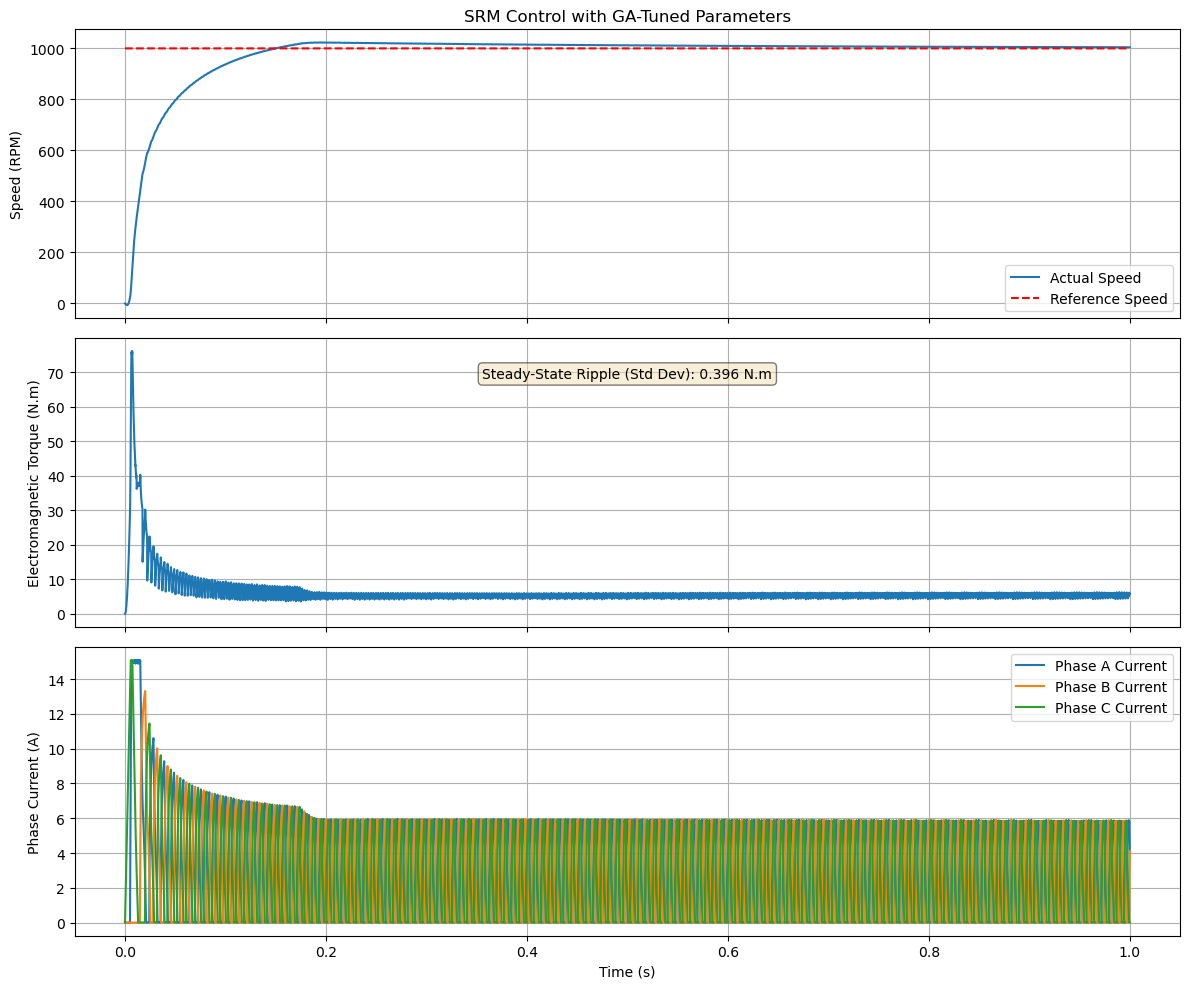

In [8]:

    # --- 1. Genetic Algorithm Configuration ---
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

BOUNDS_LOW =  [-5.0, 15.0, 0.1, 1.0]
BOUNDS_HIGH = [15.0, 40.0, 2.0, 20.0]

def create_individual():
     return [random.uniform(L, H) for L, H in zip(BOUNDS_LOW, BOUNDS_HIGH)]

toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", run_simulation_for_ga)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUNDS_LOW, up=BOUNDS_HIGH, eta=20.0)
toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUNDS_LOW, up=BOUNDS_HIGH, eta=20.0, indpb=0.2)

# --- 2. Running the Evolution ---
start_time = time.time()

POP_SIZE, NGEN, CXPB, MUTPB = 20, 10, 0.9, 0.2

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)

hof = tools.HallOfFame(1)

population = toolbox.population(n=POP_SIZE)

print("--- Starting Evolution ---")
algorithms.eaSimple(population, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=NGEN, 
                    stats=stats, halloffame=hof, verbose=True)
print("--- Evolution Finished ---")

end_time = time.time()
print(f"Total evolution time: {end_time - start_time:.2f} seconds")

best_individual = hof[0]
print("\n--- Best Individual Found ---")
print(f"  Theta On: {best_individual[0]:.4f} degrees")
print(f"  Theta Off: {best_individual[1]:.4f} degrees")
print(f"  Kp: {best_individual[2]:.4f}")
print(f"  Ki: {best_individual[3]:.4f}")
print(f"  Best Fitness (Torque Ripple): {best_individual.fitness.values[0]:.4f}")

# --- 3. Run Final Simulation and Plot ---
sim_results = run_final_simulation(best_individual)
plot_results(*sim_results)


In [1]:
pip install cupy-cuda13x

   ---------------------------------------- 0.0/33.9 MB ? eta -:--:--
   - -------------------------------------- 1.0/33.9 MB 12.7 MB/s eta 0:00:03
   - -------------------------------------- 1.0/33.9 MB 12.7 MB/s eta 0:00:03
   - -------------------------------------- 1.0/33.9 MB 12.7 MB/s eta 0:00:03
   - -------------------------------------- 1.0/33.9 MB 12.7 MB/s eta 0:00:03
   - -------------------------------------- 1.0/33.9 MB 12.7 MB/s eta 0:00:03
   -- ------------------------------------- 2.1/33.9 MB 1.8 MB/s eta 0:00:18
   --- ------------------------------------ 3.1/33.9 MB 2.3 MB/s eta 0:00:14
   ---- ----------------------------------- 4.2/33.9 MB 2.6 MB/s eta 0:00:12
   ------ --------------------------------- 5.2/33.9 MB 2.8 MB/s eta 0:00:11
   ------ --------------------------------- 5.2/33.9 MB 2.8 MB/s eta 0:00:11
   ------ --------------------------------- 5.2/33.9 MB 2.8 MB/s eta 0:00:11
   ------ --------------------------------- 5.2/33.9 MB 2.8 MB/s eta 0:00:11
 

##Cuda code

In [14]:
pip uninstall cupy-cuda11x

^C
Note: you may need to restart the kernel to use updated packages.
